In [80]:
import numpy as np

In [1]:
from google.colab import files
model_data_file = files.upload()

Saving model_data.parquet to model_data.parquet


In [2]:
import pandas as pd

model_data = pd.read_parquet(next(iter(model_data_file.keys())))
model_data.head()

,parent_asin,keep_product,eligible,observable_55d,reviews_28d,active_days_28d,avg_rating_28d,std_rating_28d,low_star_share_28d,helpful_sum_28d,...,share_5star_28d,neg_share_28d,neu_share_28d,pos_share_28d,net_rating_balance_28d,rating_polarity_28d,extreme_polarity_28d,div_rating_28d,share_reviews_7d,share_reviews_14d
0,B000FEF1V4,True,True,True,3,3,4.666667,0.577350,0.000000,44,...,0.666667,0.000000,0.0,1.000000,1.000000,1.0,0.666667,0.000000,0.333333,0.666667
1,B000GBID0M,True,True,True,3,3,4.666667,0.577350,0.000000,16,...,0.666667,0.000000,0.0,1.000000,1.000000,1.0,0.666667,0.000000,0.666667,0.666667
2,B0019WZHXI,True,True,True,3,3,5.000000,0.000000,0.000000,0,...,1.000000,0.000000,0.0,1.000000,1.000000,1.0,1.000000,0.000000,0.333333,0.666667
3,B002NT0I1W,True,True,True,3,3,5.000000,0.000000,0.000000,8,...,1.000000,0.000000,0.0,1.000000,1.000000,1.0,1.000000,0.000000,0.333333,0.333333
4,B004R2CF32,True,True,True,3,2,2.333333,2.309401,0.666667,3,...,0.333333,0.666667,0.0,0.333333,-0.333333,1.0,1.000000,0.666667,1.000000,1.000000


In [3]:
# Performing Sanity Check to ensure that shape is 8670 x 48
print('Shape of the dataset : ', model_data.shape)

Shape of the dataset :  (8670, 48)


In [4]:
# Removing all leakage and success label
leak_cols = [
    "parent_asin",
    "success_label",
    "traction_label",
    "future_reviews_28d",
    "future_avg_rating",
    "future_low_star_rating",
    "rating_delta",
    "rating_stability",     # derived using future comparisons
    "keep_product",
    "eligible",
    "observable_55d",
]

X = model_data.drop(columns= leak_cols)

In [5]:
# Check for any Null Values in features for training
X.isna().sum().value_counts()

,count
0,37


In [6]:
y = model_data['success_label'].astype(int)

In [7]:
# Correlation heatmaps are not used to pick “top features” because many engineered signals are intentionally correlated
# (counts, shares, velocity, sentiment summaries) and the target is a ranking task (Precision at K), not just linear association.
# Instead, we validate feature value through model-based evaluation

In [8]:
# Creating Train / Test Splits - Baseline Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state = 42,
    stratify = y
)

print('Train success rate : ', y_train.mean().round(3))
print('Test success rate : ', y_test.mean().round(3))

Train success rate :  0.252
Test success rate :  0.252


In [17]:
# Supervised Basline Model (Logistic Regression)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

clf_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight = "balanced"))
])

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
y_proba_lr = clf_lr.predict_proba(X_test)[:, 1]

print('AUC : ', roc_auc_score(y_test, y_proba_lr).round(3))
print('Precision : ', average_precision_score(y_test, y_proba_lr).round(3))
print(classification_report(y_test, y_pred_lr))

AUC :  0.796
Precision :  0.527
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1622
           1       0.42      0.88      0.57       546

    accuracy                           0.67      2168
   macro avg       0.68      0.74      0.65      2168
weighted avg       0.81      0.67      0.69      2168



In [18]:
import numpy as np
def precision_recall_at_k(y_true, y_score, k):
  y_true = np.array(y_true)
  y_score = np.array(y_score)
  order = np.argsort(-y_score)
  top_k = order[:k]

  prec = y_true[top_k].mean()
  rec = y_true[top_k].sum() / (y_true.sum() + 1e-9)
  return prec, rec

Ks = [20, 50, 100, 150, 250, 500]
for k in Ks:
  if k <= len(y_test):
    p,r = precision_recall_at_k(y_test, y_proba_lr, k)
    print(f"K={k:4d}  Precision={p:.3f}  Recall={r:.3f}")

K=  20  Precision=0.929  Recall=0.034
K=  50  Precision=0.901  Recall=0.082
K= 100  Precision=0.867  Recall=0.159
K= 150  Precision=0.844  Recall=0.232
K= 250  Precision=0.809  Recall=0.371
K= 500  Precision=0.755  Recall=0.691


In [15]:
X.head()

,reviews_28d,active_days_28d,avg_rating_28d,std_rating_28d,low_star_share_28d,helpful_sum_28d,helpful_mean_28d,helpful_share_pos_28d,verified_rate_28d,reviews_per_day_28d,...,share_5star_28d,neg_share_28d,neu_share_28d,pos_share_28d,net_rating_balance_28d,rating_polarity_28d,extreme_polarity_28d,div_rating_28d,share_reviews_7d,share_reviews_14d
0,3,3,4.666667,0.577350,0.000000,44,14.666667,1.0,0.666667,0.107143,...,0.666667,0.000000,0.0,1.000000,1.000000,1.0,0.666667,0.000000,0.333333,0.666667
1,3,3,4.666667,0.577350,0.000000,16,5.333333,1.0,0.333333,0.107143,...,0.666667,0.000000,0.0,1.000000,1.000000,1.0,0.666667,0.000000,0.666667,0.666667
2,3,3,5.000000,0.000000,0.000000,0,0.000000,0.0,1.000000,0.107143,...,1.000000,0.000000,0.0,1.000000,1.000000,1.0,1.000000,0.000000,0.333333,0.666667
3,3,3,5.000000,0.000000,0.000000,8,2.666667,1.0,1.000000,0.107143,...,1.000000,0.000000,0.0,1.000000,1.000000,1.0,1.000000,0.000000,0.333333,0.333333
4,3,2,2.333333,2.309401,0.666667,3,1.000000,1.0,1.000000,0.107143,...,0.333333,0.666667,0.0,0.333333,-0.333333,1.0,1.000000,0.666667,1.000000,1.000000


In [67]:
X.columns

Index(['reviews_28d', 'active_days_28d', 'avg_rating_28d', 'std_rating_28d',
       'low_star_share_28d', 'helpful_sum_28d', 'helpful_mean_28d',
       'helpful_share_pos_28d', 'verified_rate_28d', 'reviews_per_day_28d',
       'vader_mean_28d', 'vader_std_28d', 'pct_pos_28d', 'pct_neg_28d',
       'pct_neu_28d', 'vader_p95_28d', 'vader_p05_28d', 'rating_slope_28d',
       'rating_trend_enough_reviews', 'vader_slope_28d',
       'vader_trend_enough_reviews', 'reviews_7d', 'reviews_14d',
       'share_1star_28d', 'share_2star_28d', 'share_3star_28d',
       'share_4star_28d', 'share_5star_28d', 'neg_rating_share_28d',
       'neu_rating_share_28d', 'pos_rating_share_28d',
       'net_rating_balance_28d', 'rating_polarity_28d', 'extreme_polarity_28d',
       'div_rating_28d', 'share_reviews_7d', 'share_reviews_14d'],
      dtype='object')

In [57]:
# Renaming columns to assit with classification
X = X.rename(columns = {'neg_share_28d' : 'neg_rating_share_28d',
                    'neu_share_28d' : 'neu_rating_share_28d',
                    'pos_share_28d' : 'pos_rating_share_28d'})

In [70]:
# Creating Target and Traing for Ablation Tests
# Using Histogram Grtadient Boosting

# creating splits for training data
cols = X.columns.tolist()

# Saving Text-only features
text_cols  = [
    c for c in cols if (c.startswith("vader_") or c.startswith("pct_"))
]

# Saving Time-only features (review velocity, momomentum)
time_cols = ["reviews_28d", "active_days_28d", "reviews_per_day_28d", "reviews_7d", "reviews_14d",
          "share_reviews_7d", "share_reviews_14d"]

# Saving Rating only features
rating_cols = [
    c for c in cols if ( "rating" in c or "star" in c or "share_" in c or "polarity" in c )
]


# Trust / engagement columns
verified_cols = [c for c in cols if "verified" in c]
helpful_cols = [c for c in cols if "helpful" in c]

In [72]:
multi_cols = sorted(set(rating_cols + time_cols + text_cols + verified_cols + helpful_cols))

feature_sets = {

                "A_rating_only" : sorted(set(rating_cols)),
                "B_time_only" : sorted(set(time_cols)),
                "C_text_only" : sorted(set(text_cols)),
                "D_multimodal" : multi_cols,
                "E_multimodal_no_helpful" : sorted(set(multi_cols) - set(helpful_cols))
  }

for k, v in feature_sets.items():
  print(k, "number of training features = ", len(v))

A_rating_only number of training features =  20
B_time_only number of training features =  7
C_text_only number of training features =  9
D_multimodal number of training features =  37
E_multimodal_no_helpful number of training features =  34


In [74]:
# Creatijng Train / Validation / Test sets for this feature analysis
from sklearn.model_selection import train_test_split

# Followig 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.40, random_state = 42, stratify = y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.50, random_state = 42, stratify = y_temp
)

print("Train success rate : ", y_train.mean().round(3), " Val success rate", y_val.mean().round(3), " Test success rate", y_test.mean().round(3))


Train success rate :  0.252  Val success rate 0.252  Test success rate 0.251


In [110]:
# Defining Precision and Recall @K
def precision_recall_at_k(y_true, y_score, k):
  y_true = np.array(y_true)
  y_score = np.array(y_score)
  order = np.argsort(-y_score)
  top_k = order[:k]

  prec = y_true[top_k].mean()
  recall = y_true[top_k].sum() / (y_true.sum() + 1e-9)
  return prec, recall

# Defining Evaluation Ranking Metrics
def eval_rank_metrics(y_true, y_score, ks = (20, 50, 70, 100, 500)):
  out = {}
  base = float(np.mean(y_true)) # Random Precison baseline
  out['base_rate'] = base
  for k in ks:
    k_eff = min(k, len(y_true))
    prec, recall = precision_recall_at_k(y_true, y_score, k_eff)
    out[f"Prec@{k_eff}"] = round(prec, 3)
    out[f"Recall@{k_eff}"] = round(recall,3)
    out[f"Lift@{k_eff}"] = round(prec / (base + 1e-9), 3)
  return out


In [93]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

In [77]:
# Running simple model training for ablation test without cross validation to understand which works the best
def fit_eval_model(model, X_tr, ytr, Xva, yva, Xte, yte):
  model.fit(X_tr, ytr)
  p_val = model.predict_proba(Xva)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xva)
  p_test = model.predict_proba(Xte)[:,1] if hasattr(model, "predict_proba") else model.decision_function(Xte)

  res = {
      "val_pr_auc" : average_precision_score(yva, p_val),
      "val_roc_auc" : roc_auc_score(yva, p_val),
      "test_pr_auc" : average_precision_score(yte, p_test),
      "test_roc_auc" : roc_auc_score(yte, p_test)
  }
  res.update({f"val_{k}":v for k,v in eval_rank_metrics(yva, p_val).items()})
  res.update({f"test_{k}":v for k,v in eval_rank_metrics(yte, p_test).items()})
  return res, p_val, p_test


In [104]:
lr = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter = 3000, class_weight = "balanced"))
])

# Tree model pipeline (non-linear, usually better Precision@K)
hgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_leaf_nodes=31,
        min_samples_leaf=20,
        random_state=42,
        max_iter = 1000,
        max_depth = 6
    ))
])

xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=3,
        gamma = 0.8,
        reg_lambda=1,
        colsample_bytree=0.8,
        random_state=42,
        objective="binary:logistic",
        eval_metric="aucpr"
    ))
])

In [111]:
results = []

for fs_name, fs_cols in feature_sets.items():
    Xtr = X_train[fs_cols]
    Xva = X_val[fs_cols]
    Xte = X_test[fs_cols]

    # LR
    res_lr, _, _ = fit_eval_model(lr, Xtr, y_train, Xva, y_val, Xte, y_test)
    results.append({
        "model": "LogReg", "features": fs_name, "n_features": len(fs_cols),
        "test_pr_auc": res_lr["test_pr_auc"],
        "test_p@20": res_lr["test_Prec@20"],
        "test_p@50": res_lr["test_Prec@50"],
        "test_p@70": res_lr["test_Prec@70"],
        "test_p@100": res_lr["test_Prec@100"],
        "test_p@500": res_lr["test_Prec@500"],
        "test_lift@20": res_lr["test_Lift@20"],
        "test_lift@50": res_lr["test_Lift@50"],
        "test_lift@70": res_lr["test_Lift@70"],
        "test_lift@100": res_lr["test_Lift@100"],
        "test_lift@500": res_lr["test_Lift@500"],
    })

    # HGB Tree
    res_hgb, _, _ = fit_eval_model(hgb, Xtr, y_train, Xva, y_val, Xte, y_test)
    results.append({
        "model": "Tree(HGB)", "features": fs_name, "n_features": len(fs_cols),
        "test_pr_auc": res_hgb["test_pr_auc"],
        "test_p@20": res_lr["test_Prec@20"],
        "test_p@50": res_lr["test_Prec@50"],
        "test_p@70": res_lr["test_Prec@70"],
        "test_p@100": res_hgb["test_Prec@100"],
        "test_p@500": res_hgb["test_Prec@500"],
        "test_lift@20": res_lr["test_Lift@20"],
        "test_lift@50": res_lr["test_Lift@50"],
        "test_lift@70": res_lr["test_Lift@70"],
        "test_lift@100": res_hgb["test_Lift@100"],
        "test_lift@500": res_hgb["test_Lift@500"],
    })

    #XGBoost
    res_xgb, _, _ = fit_eval_model(xgb, Xtr, y_train, Xva, y_val, Xte, y_test)
    results.append({
        "model": "Tree(XGB)", "features": fs_name, "n_features": len(fs_cols),
        "test_pr_auc": res_xgb["test_pr_auc"],
        "test_p@20": res_lr["test_Prec@20"],
        "test_p@50": res_lr["test_Prec@50"],
        "test_p@70": res_lr["test_Prec@70"],
        "test_p@100": res_xgb["test_Prec@100"],
        "test_p@500": res_xgb["test_Prec@500"],
        "test_lift@20": res_lr["test_Lift@20"],
        "test_lift@50": res_lr["test_Lift@50"],
        "test_lift@70": res_lr["test_Lift@70"],
        "test_lift@100": res_xgb["test_Lift@100"],
        "test_lift@500": res_xgb["test_Lift@500"],
    })

ablation_results = pd.DataFrame(results).sort_values(["test_p@100","test_p@500"], ascending=False)
ablation_results

,model,features,n_features,test_pr_auc,test_p@20,test_p@50,test_p@70,test_p@100,test_p@500,test_lift@20,test_lift@50,test_lift@70,test_lift@100,test_lift@500
12,LogReg,E_multimodal_no_helpful,34,0.557212,0.90,0.80,0.771,0.72,0.498,3.579,3.182,3.068,2.863,1.981
9,LogReg,D_multimodal,37,0.544948,0.85,0.76,0.757,0.70,0.488,3.381,3.023,3.011,2.784,1.941
14,Tree(XGB),E_multimodal_no_helpful,34,0.532243,0.90,0.80,0.771,0.68,0.488,3.579,3.182,3.068,2.704,1.941
11,Tree(XGB),D_multimodal,37,0.530183,0.85,0.76,0.757,0.67,0.492,3.381,3.023,3.011,2.665,1.957
10,Tree(HGB),D_multimodal,37,0.470539,0.85,0.76,0.757,0.58,0.462,3.381,3.023,3.011,2.307,1.837
6,LogReg,C_text_only,9,0.435144,0.45,0.50,0.543,0.58,0.432,1.790,1.989,2.159,2.307,1.718
13,Tree(HGB),E_multimodal_no_helpful,34,0.470725,0.90,0.80,0.771,0.57,0.456,3.579,3.182,3.068,2.267,1.814
2,Tree(XGB),A_rating_only,20,0.506917,0.60,0.54,0.500,0.56,0.472,2.386,2.148,1.989,2.227,1.877
1,Tree(HGB),A_rating_only,20,0.445429,0.60,0.54,0.500,0.55,0.434,2.386,2.148,1.989,2.187,1.726
3,LogReg,B_time_only,7,0.392798,0.65,0.54,0.557,0.52,0.390,2.585,2.148,2.216,2.068,1.551


In [115]:
from sklearn.model_selection import StratifiedKFold

import shap


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42, stratify = y
)

In [116]:
text_cols

['vader_mean_28d',
 'vader_std_28d',
 'pct_pos_28d',
 'pct_neg_28d',
 'pct_neu_28d',
 'vader_p95_28d',
 'vader_p05_28d',
 'vader_slope_28d',
 'vader_trend_enough_reviews']

In [117]:
tree_cols = sorted(set(multi_cols) - set(helpful_cols) - set(text_cols))
tree_cols

['active_days_28d',
 'avg_rating_28d',
 'div_rating_28d',
 'extreme_polarity_28d',
 'low_star_share_28d',
 'neg_rating_share_28d',
 'net_rating_balance_28d',
 'neu_rating_share_28d',
 'pos_rating_share_28d',
 'rating_polarity_28d',
 'rating_slope_28d',
 'rating_trend_enough_reviews',
 'reviews_14d',
 'reviews_28d',
 'reviews_7d',
 'reviews_per_day_28d',
 'share_1star_28d',
 'share_2star_28d',
 'share_3star_28d',
 'share_4star_28d',
 'share_5star_28d',
 'share_reviews_14d',
 'share_reviews_7d',
 'std_rating_28d',
 'verified_rate_28d']

In [121]:
X_text_train = X_train[text_cols].copy()
X_text_test = X_test[text_cols].copy()

text_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter = 3000, class_weight = "balanced"))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

p_text_oof = np.zeros(len(X_text_train))
for train_index, val_index in enumerate(skf.split(X_text_train, y_train), 1):
  X_tr, X_val = X_text_train.iloc[train_index], X_text_train.iloc[val_index]
  y_tr = y_train.iloc[train_index]
  text_model.fit(X_tr, y_tr)
  p_text_oof = text_model.predict_proba(X_val)[:,1]

text_model.fit(X_text_train, y_train)
p_text_test = text_model.predict_proba(X_text_test)[:, 1]



In [122]:
def lift_at_k(y_true, y_score, k):
    base = float(np.mean(y_true))
    prec, recall = precision_recall_at_k(y_true, y_score, k)
    return prec / (base + 1e-12)

In [128]:
X_train_stack = X_train[tree_cols].copy()
X_test_stack = X_test[tree_cols].copy()

X_train_stack['p_text'] = p_text_oof
X_test_stack['p_text'] = p_text_test

xgb_model = XGBClassifier(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=2,
        gamma = 0.8,
        reg_lambda=1,
        colsample_bytree=0.9,
        random_state=42,
        objective="binary:logistic",
        eval_metric="aucpr"
)

xgb_model.fit(
    X_train_stack, y_train, verbose = False, eval_set = [(X_train_stack, y_train)]
)

proba_test = xgb_model.predict_proba(X_test_stack)[:, 1]
print("Test PR-AUC:", round(average_precision_score(y_test, proba_test), 4))

for k in [20, 50, 100, 500]:
    p, _= precision_recall_at_k(y_test, proba_test, k)
    l = lift_at_k(y_test, proba_test, k)
    print(f"Prec@{k}: {p:.3f} | Lift@{k}: {l:.3f}")

Test PR-AUC: 0.5281
Prec@20: 0.800 | Lift@20: 3.177
Prec@50: 0.760 | Lift@50: 3.018
Prec@100: 0.650 | Lift@100: 2.581
Prec@500: 0.518 | Lift@500: 2.057


In [130]:
X_shap = X_test_stack.sample(n=min(1500, len(X_test_stack)), random_state=42)
X_shap

,active_days_28d,avg_rating_28d,div_rating_28d,extreme_polarity_28d,low_star_share_28d,neg_rating_share_28d,net_rating_balance_28d,neu_rating_share_28d,pos_rating_share_28d,rating_polarity_28d,...,share_1star_28d,share_2star_28d,share_3star_28d,share_4star_28d,share_5star_28d,share_reviews_14d,share_reviews_7d,std_rating_28d,verified_rate_28d,p_text
7204,3,5.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.333333,0.000000,1.000000,0.613533
6886,3,4.000000,0.666667,0.666667,0.333333,0.333333,0.333333,0.000000,0.666667,1.000000,...,0.000000,0.333333,0.000000,0.000000,0.666667,1.000000,0.666667,1.732051,1.000000,0.257092
7413,4,4.250000,0.000000,0.500000,0.000000,0.000000,0.750000,0.250000,0.750000,0.750000,...,0.000000,0.000000,0.250000,0.250000,0.500000,0.500000,0.500000,0.957427,1.000000,0.416017
3348,10,4.933333,0.000000,0.933333,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.066667,0.933333,0.866667,0.666667,0.258199,0.066667,0.685382
6074,4,5.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.250000,0.000000,1.000000,0.663358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4308,6,4.166667,0.333333,0.833333,0.166667,0.166667,0.666667,0.000000,0.833333,1.000000,...,0.166667,0.000000,0.000000,0.166667,0.666667,0.500000,0.166667,1.602082,1.000000,0.630154
315,5,2.600000,0.800000,1.000000,0.600000,0.600000,-0.200000,0.000000,0.400000,1.000000,...,0.600000,0.000000,0.000000,0.000000,0.400000,0.400000,0.200000,2.190890,1.000000,0.116419
4064,13,3.428571,0.714286,0.642857,0.357143,0.357143,0.214286,0.071429,0.571429,0.928571,...,0.214286,0.142857,0.071429,0.142857,0.428571,0.428571,0.285714,1.696797,1.000000,0.452697
3704,3,4.666667,0.000000,0.666667,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.333333,0.666667,0.666667,0.333333,0.577350,1.000000,0.234286


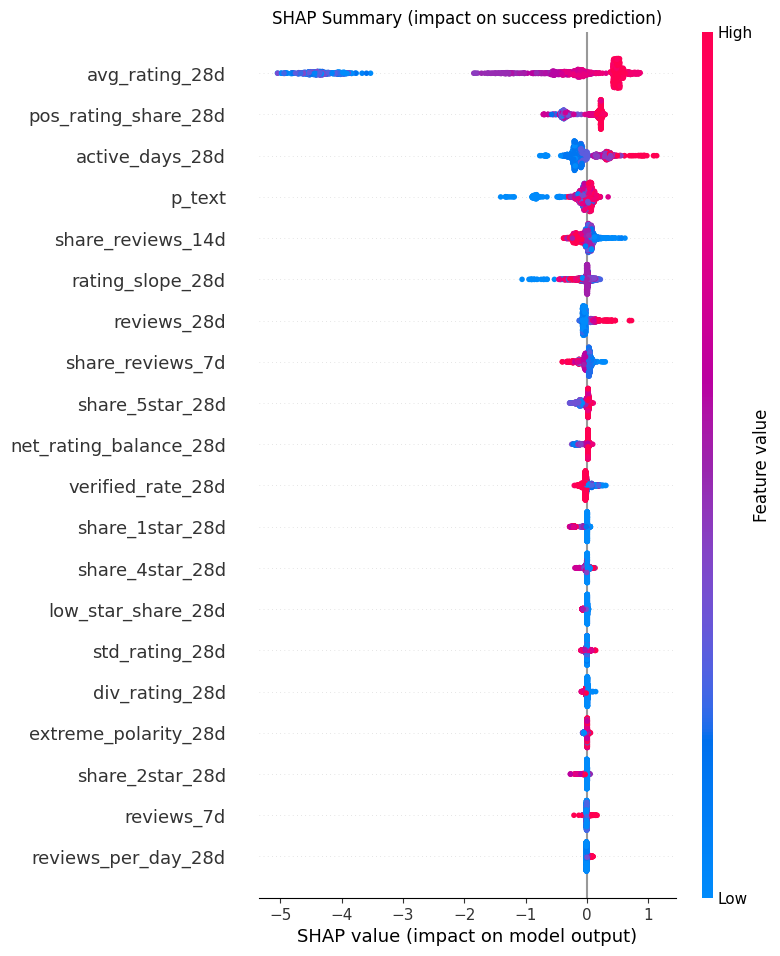

In [145]:
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

# Ploting which features matter most overall
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("SHAP Summary (impact on success prediction)")
plt.show()

In [156]:
shap_df = pd.DataFrame(shap_values, columns = X_shap.columns)

feature_importance = np.mean(np.abs(shap_values), axis = 0)
pd.Series(feature_importance, index = X_shap.columns).sort_values(ascending = False)


,0
avg_rating_28d,1.229793
pos_rating_share_28d,0.271975
active_days_28d,0.206117
p_text,0.121540
share_reviews_14d,0.091502
rating_slope_28d,0.077256
reviews_28d,0.068327
share_reviews_7d,0.057573
share_5star_28d,0.052063
net_rating_balance_28d,0.047876


In [148]:
shap_df.head()

,active_days_28d,avg_rating_28d,div_rating_28d,extreme_polarity_28d,low_star_share_28d,neg_rating_share_28d,net_rating_balance_28d,neu_rating_share_28d,pos_rating_share_28d,rating_polarity_28d,rating_slope_28d,rating_trend_enough_reviews,reviews_14d,reviews_28d,reviews_7d,reviews_per_day_28d,share_1star_28d,share_2star_28d,share_3star_28d,share_4star_28d,share_5star_28d,share_reviews_14d,share_reviews_7d,std_rating_28d,verified_rate_28d,p_text
0,-0.201842,0.494037,0.008327,0.005160,0.005500,0.0,0.017836,0.001728,0.237666,0.000280,0.007514,0.0,0.004118,-0.063039,-0.003560,-0.010094,0.003899,0.000579,0.0,-0.000098,0.018220,0.078631,0.029662,0.002494,-0.022867,0.025287
1,-0.201722,-0.136562,-0.000362,0.002991,-0.008538,0.0,0.007445,0.007497,-0.314497,0.000143,-0.276955,0.0,-0.002800,-0.040915,-0.009915,-0.006684,0.002393,-0.033674,0.0,0.011343,0.008594,-0.111889,-0.015111,0.001520,-0.045561,0.104400
2,-0.072661,-0.363039,0.005161,-0.049307,0.005371,0.0,0.054194,-0.000581,0.145624,-0.001705,-0.355919,0.0,0.000685,-0.048582,-0.003642,-0.013212,0.003411,0.000814,0.0,-0.048085,-0.018574,0.081016,-0.005728,-0.016378,-0.113779,-0.081105
3,0.387606,0.603803,0.014661,0.002839,0.005575,0.0,0.024879,0.013497,0.237340,0.002698,0.001587,0.0,0.006913,0.358713,-0.057768,0.088723,0.003975,0.004315,0.0,-0.006488,0.029283,-0.053030,-0.069465,0.007621,0.023233,0.112838
4,-0.075817,0.474732,0.008679,0.004637,0.005620,0.0,0.016498,0.001674,0.227663,0.000590,-0.000152,0.0,0.003497,-0.071314,-0.003128,-0.011677,0.003498,0.003179,0.0,0.006355,0.018211,0.103262,0.039190,0.001549,-0.020711,0.084331


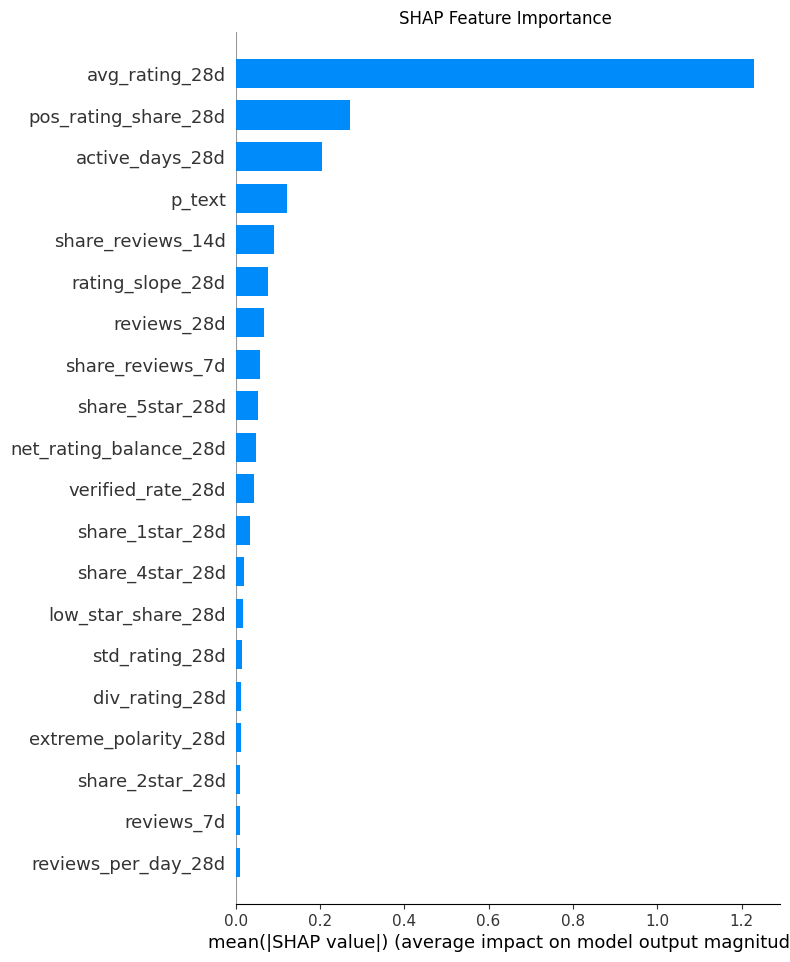

In [143]:
# Average absolute impact
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.show()

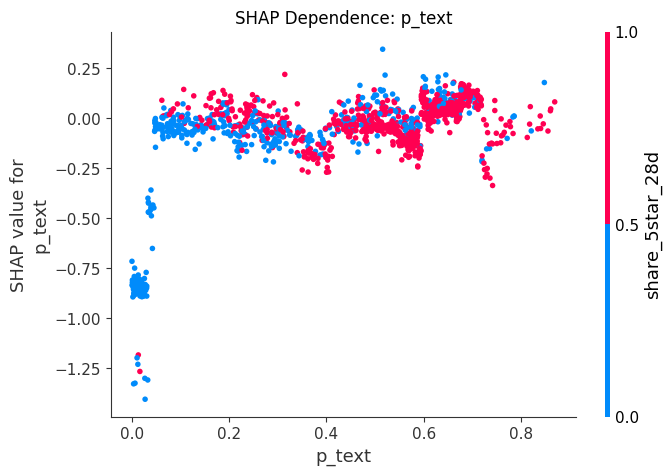

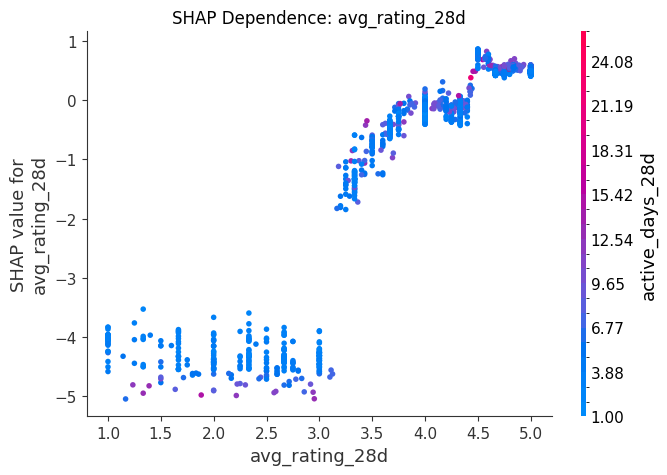

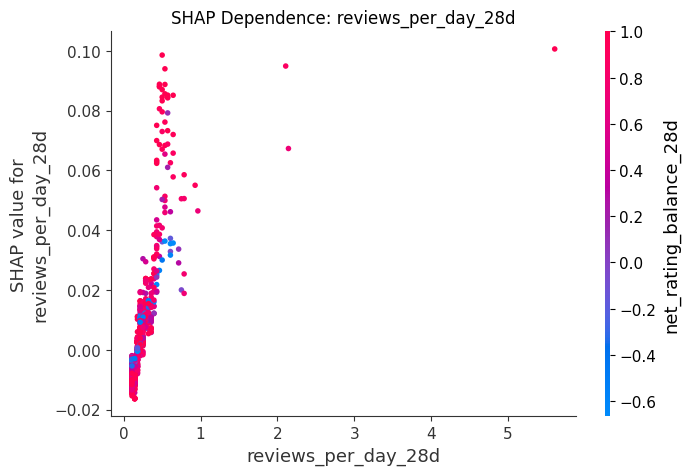

In [146]:
for feat in ["p_text", "avg_rating_28d", "reviews_per_day_28d"]:
    if feat in X_shap.columns:
        shap.dependence_plot(feat, shap_values, X_shap, show=False)
        plt.title(f"SHAP Dependence: {feat}")
        plt.show()

In [142]:
def precision_at_k(y_true, y_score, k):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = min(k, len(y_true))
    order = np.argsort(-y_score)
    topk = order[:k]
    return float(y_true[topk].mean())

def lift_at_k(y_true, y_score, k):
    base = float(np.mean(y_true))
    return precision_at_k(y_true, y_score, k) / (base + 1e-12)

# -----------------------------
# Models (same as your ablation runs)
# -----------------------------
def make_lr():
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
    ])

def make_hgb():
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=6,
            max_leaf_nodes=31,
            min_samples_leaf=30,
            random_state=42
        ))
    ])

# Optional XGBoost if installed
def make_xgb():
    try:
        import xgboost as xgb
        return Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("model", xgb.XGBClassifier(
                n_estimators=800,
                learning_rate=0.03,
                max_depth=4,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                min_child_weight=2,
                objective="binary:logistic",
                eval_metric="logloss",
                tree_method="hist",
                random_state=42
            ))
        ])
    except Exception as e:
        print("XGBoost not available:", e)
        return None

# -----------------------------
# Robustness runner (repeated seeds)
# Uses 60/20/20 splits each seed and reports TEST metrics
# -----------------------------
def run_seed_robustness(X, y, feature_cols, seeds=(0,1,2,3,4), ks=(100,500), include_xgb=False):
    rows = []
    models = {
        "LogReg": make_lr(),
        "HGB": make_hgb(),
    }
    if include_xgb:
        xgb_model = make_xgb()
        if xgb_model is not None:
            models["XGB"] = xgb_model

    X_use = X[feature_cols].copy()
    y_use = y.astype(int).copy()

    # convert bool cols to int (safe)
    for c in X_use.select_dtypes(include=["bool"]).columns:
        X_use[c] = X_use[c].astype(int)

    for seed in seeds:
        # 60/20/20 split
        X_train, X_tmp, y_train, y_tmp = train_test_split(
            X_use, y_use, test_size=0.40, random_state=seed, stratify=y_use
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_tmp, y_tmp, test_size=0.50, random_state=seed, stratify=y_tmp
        )

        base_rate = float(np.mean(y_test))

        for model_name, model in models.items():
            model.fit(X_train, y_train)

            # probability scores for ranking
            if hasattr(model, "predict_proba"):
                p_test = model.predict_proba(X_test)[:,1]
            else:
                # fallback (rare) - convert decision function to scores
                p_test = model.decision_function(X_test)

            row = {
                "seed": seed,
                "model": model_name,
                "test_base_rate": base_rate,
                "test_pr_auc": average_precision_score(y_test, p_test),
                "test_roc_auc": roc_auc_score(y_test, p_test),
            }
            for k in ks:
                row[f"test_p@{k}"] = precision_at_k(y_test, p_test, k)
                row[f"test_lift@{k}"] = lift_at_k(y_test, p_test, k)
            rows.append(row)

    df = pd.DataFrame(rows)
    return df


best_set_name = "E_multimodal_no_helpful"
best_cols = feature_sets[best_set_name]

robust_df = run_seed_robustness(
    X=X,
    y=y,
    feature_cols=best_cols,
    seeds=(0,1,2,3,4),
    ks=(20, 50, 70, 100,500),
    include_xgb=True  # set False if you don't have xgboost installed
)

# Per-seed results (you can inspect)
robust_df.sort_values(["model","seed"])

# Summary: mean ± std across seeds (this is what you cite)
summary = (robust_df
           .groupby("model")
           .agg({
               "test_pr_auc": ["mean","std"],
               "test_p@20" : ["mean", "std"],
               "test_p@50": ["mean","std"],
               "test_p@70": ["mean","std"],
               "test_p@100": ["mean","std"],
               "test_p@500": ["mean","std"],
               "test_lift@20": ["mean","std"],
               "test_lift@50": ["mean","std"],
               "test_lift@70": ["mean","std"],
               "test_lift@100": ["mean","std"],
               "test_lift@500": ["mean","std"],
           })
           .round(3))

pd.set_option('display.max_columns', None)
summary


test_pr_auc        test_p@20        test_p@50        test_p@70         \
              mean    std      mean    std      mean    std      mean    std   
model                                                                          
HGB          0.514  0.013      0.79  0.082     0.676  0.046     0.646  0.036   
LogReg       0.525  0.020      0.79  0.065     0.696  0.071     0.657  0.067   
XGB          0.503  0.013      0.76  0.102     0.672  0.054     0.640  0.034   

       test_p@100        test_p@500        test_lift@20        test_lift@50  \
             mean    std       mean    std         mean    std         mean   
model                                                                         
HGB         0.616  0.023      0.476  0.015        3.142  0.327        2.688   
LogReg      0.652  0.062      0.478  0.019        3.142  0.259        2.768   
XGB         0.592  0.022      0.469  0.010        3.023  0.408        2.673   

              test_lift@70        test_lift@100        test_lift@500         
          std         mean    std          mean    std          mean    std  
model                                                                        
HGB     0.181        2.568  0.141         2.450  0.092         1.895  0.061  
LogReg  0.283        2.613  0.266         2.593  0.247         1.901  0.077  
XGB     0.215        2.545  0.136         2.354  0.086         1.864  0.038

In [ ]:
# ============================================================
# Final Summary (Ablation → Full Model → Multi-Seed Results)
# ============================================================

# Logistic Regression ended up as the strongest and most consistent model.
#   - Best PR-AUC across all tests.
#   - Best Precision@K and Lift@K, especially at K = 50, 70, 100.
#   - Stayed the top performer across 5 different random seeds.

# XGB and HGB are competitive and confirm the patterns, but do not beat LogReg.
#   - They capture the same signal but can’t extract anything extra.
#   - Differences are small but consistent → LogReg > HGB > XGB.

# Stacking didn’t help.
#   - Scores were almost the same as single LogReg.
#   - Means the models agree on the same rankings, and we are close to the feature limit.

# From ablation:
#   - Multimodal > any single feature group.
#   - Ratings-only is the strongest single group.
#   - Text-only shows moderate signal.
#   - Time-only still beats random but is weaker.
#   - Helpful-vote features don’t add value and introduce noise.

# Top-K behavior:
#   - At K = 20/50/70 all models pick almost the same top products.
#   - LogReg separates better at K = 100+ and improves the global ranking (higher PR-AUC).

# Across seeds, metrics are stable with low std:
#   - Confirms the results are not due to one lucky split.
#   - Performance clusters around PR-AUC ~0.51–0.53 → natural ceiling for current features.

# What this means:
#   - The engineered features mostly follow clean, linear relationships.
#   - LogReg uses this structure best and gives the best simplicity-to-performance tradeoff.
#   - Tree models validate the signal but don’t add anything extra.

# Final Conclusion:
#   - Multimodal Logistic Regression (no helpful-votes) is the final recommended model.
#   - Stronger, more stable, and simpler
#   - Future improvements need new/richer features, not more complex models.
